In [ ]:
 !pip3 install nltk scikit-learn pandas
!pip3 install gensim eli5 keras tensorflow

In [ ]:
#!pip uninstall eli5
!pip install eli5
!pip install scikit-learn==1.1.3

In [ ]:
# General packages and dictionary analysis
import os
import tarfile
import bz2
import urllib.request
import re
import pickle
import nltk
import eli5
import joblib
import requests
import pandas as pd
import numpy as np
from nltk.tokenize import TreebankWordTokenizer
import matplotlib.pyplot as plt

# Supervised text classification
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.linear_model import (
    LogisticRegression)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import (
    make_pipeline, Pipeline)
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import joblib
import eli5
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Deep learning with Keras
from keras.layers import (Dense, Input,
    GlobalMaxPooling1D, Conv1D, Embedding)
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.sequence import (
    pad_sequences)
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models.keyedvectors import (
    KeyedVectors)

# Topic Modeling
import gensim
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import (
    CoherenceModel)

### Dictionaries

In [ ]:
filename = "reviewdata.pickle.bz2"
if os.path.exists(filename):
  print(f"Using cached file {filename}")
  with bz2.BZ2File(filename, "r") as zipfile:
    data = pickle.load(zipfile)
    text_train, text_test, y_train, y_test = data
else:
  url = "https://cssbook.net/d/aclImdb_v1.tar.gz"
  print(f"Downloading from {url}")
  fn, _headers = urllib.request.urlretrieve(url,
                     filename=None)
  t = tarfile.open(fn, mode="r:gz")
  text_train,text_test = [], []
  y_train, y_test = [], []
  for f in t.getmembers():
    m=re.match("aclImdb/(\w+)/(pos|neg)/", f.name)
    if not m:
        # skip folder names, other categories
        continue
    dataset, label = m.groups()
    text = t.extractfile(f).read().decode("utf-8")
    if dataset == "train":
      text_train.append(text)
      y_train.append(label)
    elif dataset == "test":
      text_test.append(text)
      y_test.append(label)
  print(f"Saving to {filename}")
  with bz2.BZ2File(filename, "w") as zipfile:
    data = text_train, text_test, y_train, y_test
    pickle.dump(data, zipfile)

Saving to reviewdata.pickle.bz2


In [ ]:
poswords = "https://cssbook.net/d/positive.txt"
negwords = "https://cssbook.net/d/negative.txt"
pos = set(requests.get(poswords).text.split("\n"))
neg = set(requests.get(negwords).text.split("\n"))
sentimentdict = {word:+1 for word in pos}
sentimentdict.update({word:-1 for word in neg})

scores = []
mytokenizer = TreebankWordTokenizer()
# For speed, we only take the first 100 reviews
for review in text_train[:100]:
    words = mytokenizer.tokenize(review)
    # we look up each word in the sentiment dict
    # and assign its value (with default 0)
    scores.append(sum(sentimentdict.get(word,0)
                      for word in words))
scores

[-3,
 -4,
 1,
 3,
 -2,
 -7,
 -6,
 9,
 7,
 7,
 10,
 5,
 -1,
 2,
 7,
 -4,
 2,
 21,
 1,
 -1,
 2,
 -3,
 -2,
 -11,
 -2,
 -3,
 -7,
 2,
 4,
 -22,
 5,
 4,
 3,
 -5,
 -8,
 1,
 -1,
 0,
 1,
 8,
 0,
 -4,
 3,
 -7,
 -11,
 -6,
 0,
 3,
 -1,
 0,
 6,
 -1,
 -8,
 7,
 -5,
 2,
 10,
 5,
 5,
 1,
 0,
 7,
 0,
 0,
 5,
 1,
 -8,
 4,
 3,
 18,
 2,
 0,
 -3,
 -2,
 5,
 0,
 -2,
 1,
 1,
 12,
 -3,
 -4,
 -6,
 -2,
 2,
 -7,
 -1,
 -10,
 -5,
 3,
 4,
 -3,
 -17,
 1,
 -1,
 7,
 -3,
 4,
 12,
 3]

### SML

In [ ]:
filename = "reviewdata.pickle.bz2"
with bz2.BZ2File(filename, "r") as f:
  txt_train,txt_test,y_train,y_test=pickle.load(f)

In [ ]:
vectorizer = CountVectorizer(stop_words="english")
X_train = vectorizer.fit_transform(txt_train)
X_test = vectorizer.transform(txt_test)

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

rep=metrics.classification_report(y_test, y_pred)
print(rep)

              precision    recall  f1-score   support

         neg       0.79      0.88      0.83     12500
         pos       0.86      0.76      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [ ]:
def short_classification_report (y_test, y_pred):
  print("    \tPrecision\tRecall")
  for label in set(y_pred):
    pr = metrics.precision_score(y_test, y_pred,
                                 pos_label=label)
    re = metrics.recall_score(y_test,y_pred,
                              pos_label=label)
    print(f"{label}:\t{pr:0.2f}\t\t{re:0.2f}")

configs = [
  ("NB-count",CountVectorizer(min_df=5,max_df=.5),
   MultinomialNB()),
  ("NB-TfIdf",TfidfVectorizer(min_df=5,max_df=.5),
   MultinomialNB()),
  ("LR-Count",CountVectorizer(min_df=5,max_df=.5),
   LogisticRegression(solver="liblinear")),
  ("LR-TfIdf",TfidfVectorizer(min_df=5,max_df=.5),
   LogisticRegression(solver="liblinear"))]

for name, vectorizer, classifier in configs:
    print(name)
    X_train = vectorizer.fit_transform(txt_train)
    X_test = vectorizer.transform(txt_test)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    short_classification_report(y_test, y_pred)
    print("\n")

NB-count
    	Precision	Recall
neg:	0.79		0.88
pos:	0.87		0.77


NB-TfIdf
    	Precision	Recall
neg:	0.80		0.88
pos:	0.87		0.78


LR-Count
    	Precision	Recall
neg:	0.85		0.87
pos:	0.87		0.85


LR-TfIdf
    	Precision	Recall
neg:	0.88		0.89
pos:	0.89		0.88




In [ ]:
for name, vectorizer, classifier in configs:
    print(name)
    pipe = make_pipeline(vectorizer, classifier)
    pipe.fit(text_train, y_train)
    y_pred = pipe.predict(text_test)
    short_classification_report(y_test, y_pred)
    print("\n")

NB with Count
    	Precision	Recall
neg:	0.79		0.88
pos:	0.87		0.77


NB with TfIdf
    	Precision	Recall
neg:	0.80		0.88
pos:	0.87		0.78


LogReg with Count
    	Precision	Recall
neg:	0.85		0.87
pos:	0.87		0.85


LogReg with TfIdf
    	Precision	Recall
neg:	0.88		0.89
pos:	0.89		0.88




In [ ]:
pipeline = Pipeline(steps = [
  ("vectorizer", TfidfVectorizer()),
  ("classifier", LogisticRegression(
      solver="liblinear"))])
grid = {"vectorizer__ngram_range": [(1,1), (1,2)],
        "vectorizer__max_df": [0.5, 1.0],
        "vectorizer__min_df": [0, 5],
        "classifier__C": [0.01, 1, 100]
       }
search=GridSearchCV(estimator=pipeline, n_jobs=-1,
  param_grid=grid,scoring="accuracy", cv=5)
search.fit(txt_train, y_train)
print(f"Best parameters: {search.best_params_}")
pred = search.predict(txt_test)
print(short_classification_report(y_test, pred))

Best parameters: {'classifier__C': 100, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 2)}
    	Precision	Recall
neg:	0.90		0.90
pos:	0.90		0.90
None


In [ ]:
nltk.download("vader_lexicon")
analyzer = SentimentIntensityAnalyzer()
pred = []
for review in text_test:
    sentiment = analyzer.polarity_scores(review)
    if sentiment["compound"]>0:
        pred.append("pos")
    elif sentiment["compound"]<0:
        pred.append("neg")
    else:
        pred.append("dont know")

print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test,pred))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/wva/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[[    0     0     0]
 [    6  6706  5788]
 [    5  1748 10747]]
              precision    recall  f1-score   support

   dont know       0.00      0.00      0.00         0
         neg       0.79      0.54      0.64     12500
         pos       0.65      0.86      0.74     12500

    accuracy                           0.70     25000
   macro avg       0.48      0.47      0.46     25000
weighted avg       0.72      0.70      0.69     25000



/home/wva/ccsbook/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wva/ccsbook/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wva/ccsbook/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make a vectorizer and train a classifier
vectorizer=TfidfVectorizer(min_df=5, max_df=.5)
classifier=LogisticRegression(solver="liblinear")
X_train=vectorizer.fit_transform(txt_train)
classifier.fit(X_train, y_train)

# Save them to disk
with open("myvectorizer.pkl",mode="wb") as f:
    pickle.dump(vectorizer, f)
with open("myclassifier.pkl",mode="wb") as f:
    joblib.dump(classifier, f)

# Later on, re-load this classifier and apply:
new_texts = ["This is a great movie",
            "I hated this one.",
            "What an awful fail"]

with open("myvectorizer.pkl",mode="rb") as f:
    myvectorizer = pickle.load(f)
with open("myclassifier.pkl",mode="rb") as f:
    myclassifier = joblib.load(f)

new_features = myvectorizer.transform(new_texts)
pred = myclassifier.predict(new_features)

for review, label in zip(new_texts, pred):
    print(f"'{review}' is probably '{label}'.")

'This is a great movie' is probably 'pos'.
'I hated this one.' is probably 'neg'.
'What an awful fail' is probably 'neg'.


In [ ]:
pipe = make_pipeline(
    TfidfVectorizer(min_df=5, max_df=.5),
    LogisticRegression(solver="liblinear"))
pipe.fit(txt_train, y_train)
eli5.show_weights(pipe, top = 10)

In [ ]:
eli5.show_prediction(classifier, txt_test[0],
                vec=vectorizer, targets=["pos"])

### CNN

In [ ]:
url="https://cssbook.net/d/dutch_sentiment.csv"
h = pd.read_csv(url)
h.head()

,id,value,lemmata
0,10007,0,Rabobank voorspellen flink stijging hypotheekr...
1,10027,0,D66 willen reserve provincie aanspreken voor g...
2,10037,1,UWV dit jaar veel baan
3,10059,1,proost op geslaagd beursgang bols
4,10099,0,helft werknemer gaan na 65ste met pensioen


In [ ]:
# Tokenize texts
tokenizer=Tokenizer(num_words=9999)
tokenizer.fit_on_texts(h.lemmata)
word_index=tokenizer.word_index
sequences=tokenizer.texts_to_sequences(h.lemmata)
tokens=pad_sequences(sequences, maxlen=1000)

# Prepare embeddings layer
fn = "w2v_320d_trimmed"
if not os.path.exists(fn):
    url = f"https://cssbook.net/d/{fn}"
    print(f"Downloading embeddings from {url}")
    urllib.request.urlretrieve(url, fn)
embeddings = KeyedVectors.load_word2vec_format(fn)
emb_matrix = np.zeros(
    (len(tokenizer.word_index) + 1,
     embeddings.vector_size))
for word, i in tokenizer.word_index.items():
    if word in embeddings:
        emb_matrix[i] = embeddings[word]
embedding_layer = Embedding(
    emb_matrix.shape[0], emb_matrix.shape[1],
    input_length=tokens.shape[1], trainable=True,
    weights=[emb_matrix])

print("Building CNN model")
sequence_input = Input(shape=(tokens.shape[1],),
                       dtype="int32")
seq = embedding_layer(sequence_input)
m = Conv1D(filters=128, kernel_size=3,
           activation="relu")(seq)
m = GlobalMaxPooling1D()(m)
m = Dense(64, activation="relu")(m)
preds = Dense(1, activation="tanh")(m)
m = Model(sequence_input, preds)
m.summary()

Building RNN model
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 320)         2176640   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 998, 128)          123008    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,307,969
Trainable params: 2,307,969
Non-trainable params: 0
______________________________

In [ ]:
# Split data into train and test
train_data = tokens[:4000]
test_data = tokens[4000:]
train_labels = h.value[:4000]
test_labels = h.value[4000:]

# Train model
m.compile(loss="mean_absolute_error",
          optimizer=RMSprop(lr=.004))
labels = np.asarray([[x] for x in train_labels])
m.fit(train_data,labels,epochs=5,batch_size=128)

# Validate against test data
output = m.predict(test_data)
# Bin output into -1, 0, 1
pred=[1 if x[0]>.3 else (0 if x[0]>-.3 else -1)
      for x in output]
correct=[x==y for (x,y) in zip(pred,test_labels)]
acc = sum(correct) / len(pred)
print(f"Accuracy: {acc}")

Train model
32/32 [==============================] - 27s 828ms/step - loss: 0.6807
Validate against test data
Accuracy: 0.46468561584840656


### LDA

In [ ]:
url = 'https://cssbook.net/d/sotu.csv'
import urllib.request

req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})

with urllib.request.urlopen(req) as response:
    sotu = pd.read_csv(response)

p_obama = (sotu[sotu.President == "Obama"]
           .text.str.split("\n\n").explode())


cv = CountVectorizer(min_df=.01,
                     stop_words="english")
dtm = cv.fit_transform(p_obama)
dtm

<738x684 sparse matrix of type '<class 'numpy.int64'>'
	with 14396 stored elements in Compressed Sparse Row format>

In [ ]:
corpus = matutils.Sparse2Corpus(dtm,
    documents_columns=False)
vocab = dict(enumerate(cv.get_feature_names()))

lda = LdaModel(corpus,id2word=vocab,num_topics=10,
    random_state=123, alpha="asymmetric")
pd.DataFrame({f"Topic {n}":[w for (w,tw) in words]
    for (n, words) in
    lda.show_topics(formatted=False)})

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,america,american,year,people,america,energy,new,america,america,new
1,american,jobs,americans,new,time,jobs,years,americans,tax,jobs
2,people,years,know,ve,ve,people,make,hard,work,just
3,new,like,people,just,new,new,jobs,people,states,help
4,right,let,new,american,year,years,work,years,americans,country
5,world,ve,american,make,years,america,need,nation,businesses,families
6,help,americans,years,time,security,just,people,work,god,make
7,economy,people,like,care,change,work,let,ve,bless,world
8,let,year,ve,like,working,world,america,world,united,government
9,know,home,make,country,work,clean,economy,time,people,fact


In [ ]:
topics = pd.DataFrame(
    [dict(lda.get_document_topics(doc,
          minimum_probability=0.0))
     for doc in corpus])
meta = (sotu.iloc[p_obama.index]
        .drop(columns=["text"])
        .reset_index(drop=True))
tpd = pd.concat([meta, topics], axis=1)
tpd.head()

,FirstName,President,Date,delivery,type,party,0,1,2,3,4,5,6,7,8,9
0,Barack,Obama,2009-02-24,spoken,other,Democratic,0.022992,0.905657,0.013875,0.011605,0.009984,0.008761,0.007804,0.007036,0.006406,0.005879
1,Barack,Obama,2009-02-24,spoken,other,Democratic,0.017550,0.012980,0.010400,0.008707,0.007489,0.922529,0.005853,0.005277,0.004805,0.004410
2,Barack,Obama,2009-02-24,spoken,other,Democratic,0.517581,0.005989,0.253414,0.207138,0.003456,0.003033,0.002702,0.002436,0.002218,0.002035
3,Barack,Obama,2009-02-24,spoken,other,Democratic,0.946834,0.010359,0.008321,0.006964,0.005991,0.005256,0.004683,0.004222,0.003844,0.003528
4,Barack,Obama,2009-02-24,spoken,other,Democratic,0.008809,0.006493,0.005202,0.962295,0.003744,0.003285,0.002927,0.002639,0.002402,0.002205


In [ ]:
for docid in [622, 11, 322]:
    print(f"{docid}: {list(p_obama)[docid]}")

622: I intend to protect a free and open Internet, extend its reach to every classroom and every community and help folks build the fastest networks so that the next generation of digital innovators and entrepreneurs have the platform to keep reshaping our world. I want Americans to win the race for the kinds of discoveries that unleash new jobs: converting sunlight into liquid fuel; creating revolutionary prosthetics so that a veteran who gave his arms for his country can play catch with his kids again; pushing out into the solar system not just to visit, but to stay. Last month, we launched a new spacecraft as part of a reenergized space program that will send American astronauts to Mars. And in 2 months, to prepare us for those missions, Scott Kelly will begin a year-long stay in space. So good luck, Captain. Make sure to Instagram it. We're proud of you.
11: Because of this plan, there are teachers who can now keep their jobs and educate our kids, health care professionals can cont

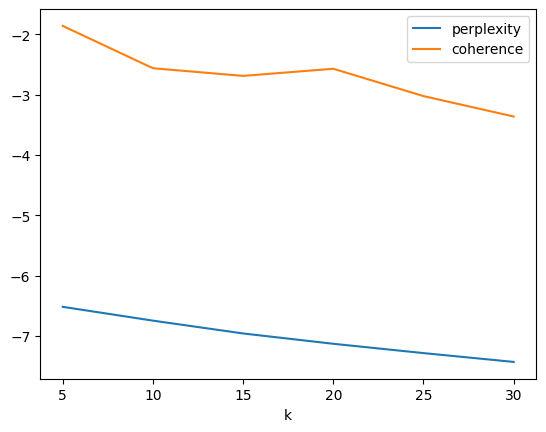

In [ ]:
result = []
for k in [5, 10, 15, 20, 25, 30]:
  m = LdaModel(corpus,num_topics=k,id2word=vocab,
          random_state=123, alpha="asymmetric")
  perplexity = m.log_perplexity(corpus)
  coherence=CoherenceModel(model=m,corpus=corpus,
      coherence="u_mass").get_coherence()
  result.append(dict(k=k, perplexity=perplexity,
                     coherence=coherence))

result = pd.DataFrame(result)
result.plot(x="k", y=["perplexity", "coherence"])
plt.show()